In [3]:
import importlib
import numpy as np
from utils import (
    extraction,
    generic_helper,
    experiment,
    plotting,
    structure_noah
)
from utils.definitions import ROOT_DIR
importlib.reload(generic_helper)
importlib.reload(extraction)
importlib.reload(experiment)
importlib.reload(plotting)
importlib.reload(structure_noah)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<module 'utils.structure_noah' from '/home/s2228293/Documents/macmigs_year2/semester2/pulse_project/utils/structure_noah.py'>

In [4]:
# define some constants
PATH_TO_DATA = f"{ROOT_DIR}/data"
PATH_TO_MODEL = f"{ROOT_DIR}/models"
REFINED_DATA =  generic_helper.read_data(
    path=PATH_TO_DATA,
    fname="noah_structured_data_refined.pkl"
)
SPLIT_DATA = generic_helper.read_data(
    path=f"{ROOT_DIR}/data",
    fname="noah_train_val_test_split.pkl"
)

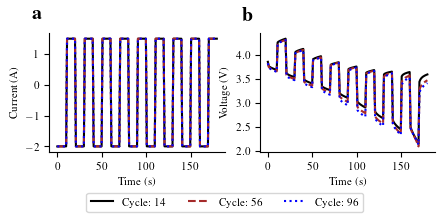

In [5]:
# check some pulse voltage for some cells
sample_cells = list(REFINED_DATA.keys())[:4]
plotting.plot_pulse_voltage_current(
    structured_data_with_pulse=REFINED_DATA,
    sample_cell=sample_cells[1]
)

In [ ]:
# plot first pulse cycle distribution 
plotting.distribution_of_firstpulse_cycle_life(
    structured_data_with_pulse=REFINED_DATA,
    pulse=True
)

In [ ]:
# plot cells' end of life distribution
plotting.distribution_of_firstpulse_cycle_life(
    structured_data_with_pulse=REFINED_DATA
)

In [ ]:
# plot sample filtered capacity
cathode_groups = structure_noah.get_unique_cathode_groups(structured_data=REFINED_DATA)
cells_to_plot_for_filtered_capacity = []

for cathode_group in cathode_groups:
    data_grp = {k:REFINED_DATA[k] for k in REFINED_DATA
                if REFINED_DATA[k]['summary']['cathode_group']==cathode_group
            }
    cells_to_plot_for_filtered_capacity.append(
        np.random.choice(list(data_grp.keys()))
      )  # just choose a cell in the group at random

plotting.plot_filtered_capacity(
    sample_cells=cells_to_plot_for_filtered_capacity,
    structured_data=REFINED_DATA
)

In [ ]:
# get the end of life for training cells
_, eol_data = extraction.get_data_for_eol_prediction(
    structured_data=SPLIT_DATA["train"],
    signature_depth=2,    # for completeness, we need only eol
     threshold=120
)

# get the rul for the training cells
_, rul_data = extraction.get_data_for_rul_prediction(
    structured_data=SPLIT_DATA["train"],
    signature_depth=2,    # for completeness, we need only rul
    threshold=120
)

# compare eol and its quantile transformation
plotting.plot_target_transform_comparison(
    data=eol_data,
    bins=25,
    x_label="End of life",
    save_name="eol_transfromation_comparison"
)

# for the remaining useful life 
plotting.plot_target_transform_comparison(
    data=rul_data,
    bins=25,
    x_label="Remaining useful life",
    save_name="rul_transfromation_comparison"
)


In [ ]:
# parity plot for eol and rul
prediction_data_list = [
    generic_helper.read_data(path=PATH_TO_DATA, fname=fname)
    for fname in ["eol_prediction_data.pkl", "rul_prediction_data.pkl"]
]
plotting.parity_plot(
    prediction_data_list=prediction_data_list,
    tag="eol_rul_parity"
)

In [ ]:
# plot roc curve and confusion matrix
classification_prediction_data =  generic_helper.read_data(
    path=PATH_TO_DATA,
    fname="classification_prediction_data.pkl"
)
plotting.plot_cunfusion_matrix_roc_curve(
    y_true=classification_prediction_data["y_true"],
    y_pred=classification_prediction_data["y_pred"],
    y_score=classification_prediction_data["y_score"],
    classes=["Passed", "Not passed"]
)


In [ ]:
# plot feature importance 
model_names = ["eol", "rul", "classification"]
depths = [3, 6, 6]
model_feature_dict = {
    name: {
        "pipeline": generic_helper.read_data(
            path=PATH_TO_MODEL, fname=f"{name}_pipeline.pkl"
        ),
        "fitted_model": generic_helper.read_data(
            path=PATH_TO_MODEL, fname=f"{name}_model.pkl"
        ),
        "features": generic_helper.get_sig_convention(
            dimension=3, depth=depth
        ),
    }
    for name, depth in zip(model_names, depths)
}


for m in ["xgboost", "permutation", "shap"]:

    analysis_result = experiment.feature_importance_analysis(
        model_feature_dict=model_feature_dict,
        mode=m,
        validation_set=None if m == "xgboost" else SPLIT_DATA['train']
    )
    plotting.plot_feature_importance(
        analysis_result=analysis_result,
        threshold=10,
        tag=f"{m}_feature_importance"
    )

In [ ]:

# plot number of cells per group and first pulse cycle distribution
plotting.plot_num_cells_first_pulse_dist(
    structured_data_with_pulse=REFINED_DATA
)

In [ ]:
# plot the effect of time threshold on models
threshold_data_dict = {
    model_name: generic_helper.read_data(
            path=PATH_TO_DATA, fname=f"{model_name}_threshold_data.pkl")
    for model_name in ["rul", "classification"]
    
}

plotting.plot_time_threshold_effect(
    threshold_data_dict=threshold_data_dict
)

In [ ]:
# plot the effect of time threshold on feature importance 
importlib.reload(plotting)
plotting.plot_combined_feature_similarity(
    data_list=[
        generic_helper.read_data(path=PATH_TO_DATA, fname=f"{m}_threshold_feature_importance.pkl")
        for m in ["eol", "rul", "classification"]
    ]
)

In [ ]:
plotting.graphical_abstract(
    prediction_data_list=prediction_data_list,
    analysis_result=analysis_result
)

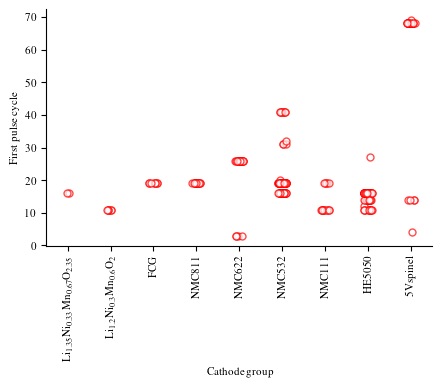

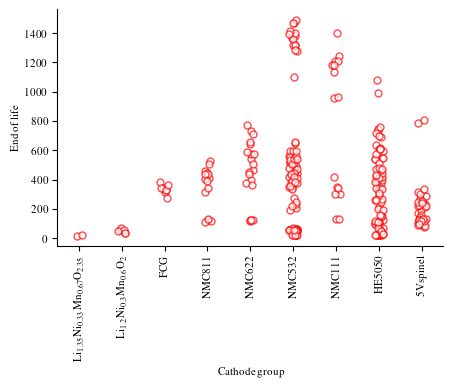

In [76]:
# get stripplot of first pulse cycles and end of life
for fl, yl in zip( [True, False], ["First pulse cycle", "End of life"]):

    plotting.strip_plot_firstpulse_cycle_life(
        structured_data_with_pulse=REFINED_DATA,
        pulse_cycle=fl,
        ylabel=yl,

    )